In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [7]:
!fusermount -u drive
!google-drive-ocamlfuse drive

/bin/bash: google-drive-ocamlfuse: command not found


In [14]:
import pandas as pd
import fastai
from fastai.text.all import *
df_all= pd.read_csv("/content/gdrive/MyDrive/train_tiny_folds_lstm.csv")
df_all.head()

,id,question,OpenStatus,kfold
0,1661369,"How does C Handle Integers with Leading Zeros? When you create an integer with leading zeros, how does c handle it? Is it different for different versions of C?\r\n\r\nIn my case, they just seem to be dropped (but maybe that is what printf does?):\r\n\r\n #include <stdio.h>\r\n \r\n int main() {\r\n int a = 005;\r\n printf(""%i\n"", a);\r\n return 0;\r\n }\r\n\r\nI know I can use printf to pad with 0s, but I am just wondering how this works.",1,0
1,6755283,"how to parse a function and it's arguments For my lexer i'm using the `boost::wave` lexical iterator which gives me all the tokens. Now i want to find if a set of tokens i.e. an identifier followed by `open parenthesis` and then set of arguments separated by `comma` and finally `closed parenthesis`, is a function in a C++ program. I mean how should i analyze the set of tokens to make sure i have a function. I am trying to implement this using a recursive descent parser. Till now my (recursive descent parser) can parse arithmetic expressions and take care of (almost) all kinds of operator p...",1,0
2,8133788,"Time to the next alarm in seconds or milliseconds With this code I am able to take some string like ""Wed 10:10"", \r\n\r\n String nextAlarm = Settings.System.getString(getContentResolver(),\r\n Settings.System.NEXT_ALARM_FORMATTED);\r\n\r\nbut I want to have a value of seconds to the next alarm. Is that possible ?\r\nAlso it would be nice for me if I am able to read the value of the description field, and the days when this alarm is enabled.\r\n\r\n\r\n",1,0
3,481059,Masked TextBox in WPF Do you know any freely available WPF component for using masks (regex) in textbox?,1,0
4,10386026,"T-SQL: Conditionally joining using a parameter Consider a simple join:\r\n\r\nSelect TableB.* From TableA Inner Join TableB On TableB.ID = TableA.ID\r\n\r\nWhat I want to do is decide which table to join to depending on a parameter. Although the following syntax is not valid, I wrote it just to illustrate what I am after:\r\n\r\nSelect TableD.* From TableA Inner Join [If @useTableC = 1 Then Join to TableC Else Join to TableB] As TableD\r\n\r\nBoth TableB and TableC have identical columns.\r\n\r\nHow can I create this kind of join. Please be aware that this example is actually a small porti...",1,0


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33706 entries, 0 to 33705
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          33706 non-null  int64 
 1   question    33706 non-null  object
 2   OpenStatus  33706 non-null  int64 
 3   kfold       33706 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.0+ MB


In [16]:
df_all.OpenStatus.value_counts()

1    33005
0      701
Name: OpenStatus, dtype: int64

In [4]:
from sklearn.metrics import confusion_matrix
conf= confusion_matrix

fold 0
1    33005
0      701
Name: OpenStatus, dtype: int64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxup xml xxup rpc via xxup xmpp xxmaj i 'm currently trying to implement xxup xml xxup rpc via xxup xmpp . xxmaj i 'm using xxmaj smack as client library and xxmaj xxunk as xxup xmpp server . xxmaj simplified , my setup looks as follows : \r\n\r\n * * [ client1 ] — [ server ] — [ xxunk ] * * \r\n\r\n i want to invoke a method on xxmaj client 2 from xxmaj client 1 . i create an xxup iq with type set , and from and to elements and the query content as described in [ 1 ] . xxmaj simplified example : \r\n\r\n▁ < iq xxunk ' xxunk ' xxunk ' xxunk ' > \r\n▁ < query xxunk : iq : rpc ' > \r\n▁ < methodcall > \r\n▁ < methodname > foo < / methodname","xxup xml xxup rpc via xxup xmpp xxmaj i 'm currently trying to implement xxup xml xxup rpc via xxup xmpp . xxmaj i 'm using xxmaj smack as client library and xxmaj xxunk as xxup xmpp server . xxmaj simplified , my setup looks as follows : \r\n\r\n * * [ client1 ] — [ server ] — [ xxunk ] * * \r\n\r\n i want to invoke a method on xxmaj client 2 from xxmaj client 1 . i create an xxup iq with type set , and from and to elements and the query content as described in [ 1 ] . xxmaj simplified example : \r\n\r\n▁ < iq xxunk ' xxunk ' xxunk ' xxunk ' > \r\n▁ < query xxunk : iq : rpc ' > \r\n▁ < methodcall > \r\n▁ < methodname > foo < / methodname >"
1,"to determine if url is being requested from xxmaj facebook iframe ? i have a xxmaj google xxmaj app xxmaj engine application and i want to serve a different django template if the request comes in from the xxmaj facebook xxmaj application . xxmaj how can i detect that ? i do n't see anything unique in the xxmaj header . xxbos xxmaj android web app screen css issue ? i have a mobile application that i am building , it is made to support android , iphone and probably blackberry . xxmaj most of the css and formatting is coded on a 1024px . i have formatted the site using an iphone because it was in hand . xxmaj after trying the site on an android , the site seems to load as if the phone believes it is a full screen .","determine if url is being requested from xxmaj facebook iframe ? i have a xxmaj google xxmaj app xxmaj engine application and i want to serve a different django template if the request comes in from the xxmaj facebook xxmaj application . xxmaj how can i detect that ? i do n't see anything unique in the xxmaj header . xxbos xxmaj android web app screen css issue ? i have a mobile application that i am building , it is made to support android , iphone and probably blackberry . xxmaj most of the css and formatting is coded on a 1024px . i have formatted the site using an iphone because it was in hand . xxmaj after trying the site on an android , the site seems to load as if the phone believes it is a full screen . xxmaj"


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.315141,3.993444,0.308699,54.241386,04:26


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.885558,3.728172,0.346283,41.603001,04:41
1,3.647030,3.516443,0.372272,33.664471,04:42
2,3.493233,3.396778,0.388196,29.867722,04:42
3,3.349689,3.324145,0.395920,27.775249,04:42
4,3.248401,3.274486,0.401940,26.429646,04:43
5,3.191952,3.236199,0.406311,25.436844,04:42
6,3.109041,3.210099,0.410265,24.781527,04:42
7,3.031225,3.195346,0.412602,24.418617,04:42
8,2.994086,3.187466,0.413779,24.226963,04:42
9,2.985665,3.188108,0.413940,24.242517,04:42


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.099830,0.088761,0.978196,0.787107,02:02


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.093323,0.088365,0.978048,0.797209,02:20


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.087912,0.089011,0.977158,0.800706,03:31


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.078443,0.094713,0.977306,0.771528,04:29
1,0.073527,0.105538,0.974933,0.784495,04:28


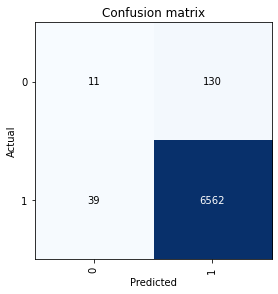

In [17]:
fold = 0
for folds in range(1):
  print("fold",folds)
  df=df_all.copy()
  mask1 = df.kfold==folds
  mask2 = df.kfold!=folds
  column_name ='is_valid'
  df.loc[mask1,column_name] = True
  df.loc[mask2,column_name] =False
  print(df.OpenStatus.value_counts())
  dls_lm = TextDataLoaders.from_df(df,text_col='question', label_col='OpenStatus',
                                valid_col='is_valid',seq_len=144,is_lm=True)
  
  dls_lm.show_batch(max_n=2)  
  learn = language_model_learner(dls_lm,AWD_LSTM,metrics=[accuracy,Perplexity],wd=0.1,path='').to_fp16()
  learn.fit_one_cycle(1,1e-2)
  learn.save('1epoch')
  learn = learn.load('1epoch')
  learn.unfreeze()
  learn.fit_one_cycle(10,1e-3)
  learn.save_encoder('finetuned')

  #classification
  dls_clas = TextDataLoaders.from_df(df,text_col='question', label_col='OpenStatus',
                                valid_col='is_valid',seq_len=144,text_vocab=dls_lm.vocab)

  roc_score=RocAucBinary() 
  learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy, roc_score])
  learn=learn.load_encoder('finetuned')
  learn.fit_one_cycle(1,2e-2)
  learn.freeze_to(-2)
  learn.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2))
  learn.freeze_to(-3)
  learn.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3))
  learn.unfreeze()
  learn.fit_one_cycle(2,slice(1e-3/(2.6**4),5e-3))
  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix()

fold 1
1    33005
0      701
Name: OpenStatus, dtype: int64


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxup ssh to server behind firewall i am currently trying to work out how to xxup ssh to servers behind firewalls that deny all incoming connections . xxmaj the servers can xxup ssh out , so i am wondering if there is a way to get the server behind the firewall to create an xxup ssh tunnel to my workstation , then allow my workstation to send commands back to the server through it ? \r\n\r\n i have looked into tunneling / reverse tunneling , but these appear to be port forwarding solutions , which will not work as the firewall xxunk all connections on all ports . \r\n\r\n xxmaj ideally , i would like to do this in xxmaj ruby ( using the xxunk gem ) , such that instead of opening a new connection like : \r\n\r\n▁ xxunk ' , '","xxup ssh to server behind firewall i am currently trying to work out how to xxup ssh to servers behind firewalls that deny all incoming connections . xxmaj the servers can xxup ssh out , so i am wondering if there is a way to get the server behind the firewall to create an xxup ssh tunnel to my workstation , then allow my workstation to send commands back to the server through it ? \r\n\r\n i have looked into tunneling / reverse tunneling , but these appear to be port forwarding solutions , which will not work as the firewall xxunk all connections on all ports . \r\n\r\n xxmaj ideally , i would like to do this in xxmaj ruby ( using the xxunk gem ) , such that instead of opening a new connection like : \r\n\r\n▁ xxunk ' , ' user"
1,"xxup init xxup sender xxup socket \r\n▁\t▁ / / xxrep 3 > xxmaj step # 1 xxrep 3 < \r\n▁\t▁ / / xxmaj create a socket \r\n▁\t▁ / / - xxup af_inet is xxmaj address xxmaj family xxmaj internet and xxup sock_dgram is datagram \r\n▁\t▁ xxunk = socket(af_inet , xxup sock_dgram , 0 ) ; \r\n▁\t▁ if ( xxunk < 0 ) \r\n▁\t▁ { \r\n▁\t▁ printf ( "" xxrep 3 * xxup error - socket ( ) failed \n "") ; \r\n▁\t▁ exit(-1 ) ; \r\n▁\t▁ } \r\n▁\t▁ printf ( "" xxrep 3 * xxmaj sender -- socket created \n "") ; \r\n▁\t▁ / / xxrep 3 > xxmaj step # 2 xxrep 3 < \r\n▁\t▁ / / xxmaj fill - in server1 socket 's address information \r\n▁\t▁ server_addr.sin_family = xxup af_inet ; / / xxmaj address family to use \r\n▁\t▁ server_addr.sin_port = htons(port_num","init xxup sender xxup socket \r\n▁\t▁ / / xxrep 3 > xxmaj step # 1 xxrep 3 < \r\n▁\t▁ / / xxmaj create a socket \r\n▁\t▁ / / - xxup af_inet is xxmaj address xxmaj family xxmaj internet and xxup sock_dgram is datagram \r\n▁\t▁ xxunk = socket(af_inet , xxup sock_dgram , 0 ) ; \r\n▁\t▁ if ( xxunk < 0 ) \r\n▁\t▁ { \r\n▁\t▁ printf ( "" xxrep 3 * xxup error - socket ( ) failed \n "") ; \r\n▁\t▁ exit(-1 ) ; \r\n▁\t▁ } \r\n▁\t▁ printf ( "" xxrep 3 * xxmaj sender -- socket created \n "") ; \r\n▁\t▁ / / xxrep 3 > xxmaj step # 2 xxrep 3 < \r\n▁\t▁ / / xxmaj fill - in server1 socket 's address information \r\n▁\t▁ server_addr.sin_family = xxup af_inet ; / / xxmaj address family to use \r\n▁\t▁ server_addr.sin_port = htons(port_num )"


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.306540,4.003561,0.304739,54.792923,04:27


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.874503,3.740707,0.342272,42.127769,04:52
1,3.654639,3.537352,0.368227,34.375759,04:42
2,3.430633,3.417376,0.380605,30.489292,04:44
3,3.277994,3.337526,0.391414,28.149401,04:41
4,3.236820,3.285862,0.397027,26.732010,04:40


epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.874503,3.740707,0.342272,42.127769,04:52
1,3.654639,3.537352,0.368227,34.375759,04:42
2,3.430633,3.417376,0.380605,30.489292,04:44
3,3.277994,3.337526,0.391414,28.149401,04:41
4,3.236820,3.285862,0.397027,26.732010,04:40
5,3.149795,3.245033,0.402564,25.662563,04:42
6,3.115597,3.221409,0.405922,25.063417,04:49
7,2.974171,3.205839,0.408147,24.676188,04:46
8,3.014079,3.200062,0.409212,24.534046,04:44
9,2.955843,3.200768,0.409370,24.551390,04:45


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.105602,0.088323,0.978935,0.779346,02:01


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.085999,0.085330,0.979528,0.810281,02:20


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.076251,0.086446,0.978342,0.818849,03:29


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.094366,0.091320,0.979232,0.799950,04:29
1,0.072572,0.094860,0.976561,0.811856,04:29


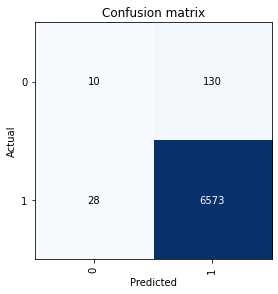

In [20]:
fold = 0
for folds in range(1,2):
  print("fold",folds)
  df=df_all.copy()
  mask1 = df.kfold==folds
  mask2 = df.kfold!=folds
  column_name ='is_valid'
  df.loc[mask1,column_name] = True
  df.loc[mask2,column_name] =False
  print(df.OpenStatus.value_counts())
  dls_lm = TextDataLoaders.from_df(df,text_col='question', label_col='OpenStatus',
                                valid_col='is_valid',seq_len=144,is_lm=True)
  
  dls_lm.show_batch(max_n=2)  
  learn = language_model_learner(dls_lm,AWD_LSTM,metrics=[accuracy,Perplexity],wd=0.1,path='').to_fp16()
  learn.fit_one_cycle(1,1e-2)
  learn.save('1epoch')
  learn = learn.load('1epoch')
  learn.unfreeze()
  learn.fit_one_cycle(10,1e-3)
  learn.save_encoder('finetuned')

  #classification
  dls_clas = TextDataLoaders.from_df(df,text_col='question', label_col='OpenStatus',
                                valid_col='is_valid',seq_len=144,text_vocab=dls_lm.vocab)

  roc_score=RocAucBinary() 
  learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy, roc_score])
  learn=learn.load_encoder('finetuned')
  learn.fit_one_cycle(1,2e-2)
  learn.freeze_to(-2)
  learn.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2))
  learn.freeze_to(-3)
  learn.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3))
  learn.unfreeze()
  learn.fit_one_cycle(2,slice(1e-3/(2.6**4),5e-2))
  interp = ClassificationInterpretation.from_learner(learn)
  interp.plot_confusion_matrix()

In [19]:
for folds in range(1,2):
  print(folds)

1
